In [32]:
%load_ext autoreload
%autoreload 2




        

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

np.random.seed(13)
torch.manual_seed(13)

plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The model will be trained with", device)



The model will be trained with cuda


In [34]:
from environments.SnowmanEnvironment import SnowmanEnvironment
map_path = './Dades/andy.txt'
save_path = './trainedModels/david1.pt'
map_rows=9
map_cols=9
n_actions = 4 #Modifica quan implementi gym
map_layers = 1

snowman_env = SnowmanEnvironment(map_file=map_path, 
                                 n=map_rows, m=map_cols, 
                                 stop_when_error=False, 
                                 stop_when_dumb=False, 
                                 enable_step_back_optimzation=False, 
                                 enable_blocked_snowman_optimization=True,
                                 enable_snowball_number_optimization=True,
                                 enable_snowball_distances_optimization=True)


n,m:  9 9
setting agent position to  4 4


In [35]:
from utils.ReplayMemory import ReplayMemory
from utils.ReplayMemory import Transition

memory = ReplayMemory(100000)


In [36]:
from neuralNests.ConvNet_v1 import DQN
policy_net = DQN(map_layers, n_actions, map_rows, map_cols).to(device)
target_net = DQN(map_layers, n_actions, map_rows, map_cols).to(device)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [37]:

from trainingAgents.SnowmanTrainingAgent import TrainingAgent

BATCH_SIZE = 256 #mida del batch del replay
GAMMA = 0.99 #factor de descompte de les recompeses futures
EPS_START = 1 #valor inicial de la epsilon per la epsilon greedy policy
EPS_END = 0.05 #valor final de la epsilon per la epsilon greedy policy
EPS_DECAY = 10000 #controla la caiguda expoencial del valor epsilon, com més alt, mes lent disminueix
TAU = 0.005 #controla cada quan s'actualitza la target network
LR = 1e-4 #Learning rate de l'optimitzador
RANDOMIZE_AGENT_POSITION_EACH_EPISODE = True


In [38]:

INITIAL_RANDOM_STEPS = 0


optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
training_agent = TrainingAgent(policy_net, target_net, optimizer, memory, EPS_END, EPS_START, EPS_DECAY, GAMMA, BATCH_SIZE, INITIAL_RANDOM_STEPS, device)



In [39]:

print("***************************ENCODED MAP****************************")
snowman_env.show_map(SnowmanEnvironment.ENCODED_TEXT_MODE)
print("\n")
print("***************************DECODED MAP****************************")
snowman_env.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)
snowman_env.randomize_agent_position()
snowman_env.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)
print("\n")

***************************ENCODED MAP****************************
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  9.  9.  9.  9.  9.  0.  0.]
 [ 0.  0.  9.  1.  9.  1.  8.  0.  0.]
 [ 0.  0.  9.  9. 10.  8.  8.  0.  0.]
 [ 0.  0.  9.  1.  8.  8.  8.  0.  0.]
 [ 0.  0.  8.  8.  8.  9.  9.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]


***************************DECODED MAP****************************
[['#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '.' '.' '.' '.' '.' '#' '#']
 ['#' '#' '.' '1' '.' '1' ',' '#' '#']
 ['#' '#' '.' '.' 'p' ',' ',' '#' '#']
 ['#' '#' '.' '1' ',' ',' ',' '#' '#']
 ['#' '#' ',' ',' ',' '.' '.' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#']]
[['#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '.' '.' '.' '.' '.' '#' '#']
 ['#' '#' '.' '1' '.' '1' ',' '#' '#']
 ['#

MAIN TRAINING LOOP

In [40]:
episodes=100000
jugades=100
rewards = []
rewards_per_jugada = []

best_score = -100000
tau_mode = False



In [41]:
    

for episode in range(episodes):
    state, info = snowman_env.reset()
    if RANDOMIZE_AGENT_POSITION_EACH_EPISODE:
        state, info = snowman_env.randomize_agent_position()
    
    #Convertim l'estat a un tensor. Fem unsqueeze perquè la xarxa neuronal s'espera un batch de mapes, i state es un sol mapa.
    #Per tant li passem un batch de un sol mapa encapsulant en un array (o tensor)

    #Separem les capes de l'estat (mapa) en una capa per cada tipus de casella:
    #state = snowman_env.split_map_layers(state)
    state_array = np.array(state, dtype=np.float32)
    state = torch.tensor([state], dtype=torch.float32, device=device).unsqueeze(0)
    rewards_string = []
    act_rewards = []
    nJuagades = 0
    for jugada in range(jugades):
        if RANDOMIZE_AGENT_POSITION_EACH_EPISODE and jugada % 50 == 0 and False:
            state, info = snowman_env.randomize_agent_position()
            state = torch.tensor([state], dtype=torch.float32, device=device).unsqueeze(0)

        nJuagades = nJuagades+1
        #Triem una accio segons la politica epsilon greedy
        isRandom, action = training_agent.select_action_epsilon_greedy(state, snowman_env)
        next_state, reward, done, _ = snowman_env.step(action.item())
        act_rewards.append(reward)
        rewards_per_jugada.append(reward)
        rewards_string.append(str(reward) if isRandom else reward)
        if reward >= best_score:
            best_score = reward

        #Conevrtim el reward a un tensor i el seguent state a un tensor, aixi ho guardem al replay_memory tot en tensors:
        reward = torch.tensor([reward], device=device)
        if done:
            next_state = None
        else:
            #next_state = torch.tensor(snowman_env.split_map_layers(next_state), dtype=torch.float32, device=device).unsqueeze(0)
            next_state = torch.tensor([next_state], dtype=torch.float32, device=device).unsqueeze(0)

        
        training_agent.replay_memory.push(state,action, next_state, reward)

        #Anem al seguent estat
        state = next_state

        #OPTIMIZATION
        training_agent.training_step()
        


       
        
        #print("epsilon: ",EPS_END + (EPS_START - EPS_END) * math.exp(-1. * training_agent.steps_done / EPS_DECAY))
        #print("reward", reward.item())
        #snowman_env.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)
        if done:
            break
        #time.sleep(1)

        #Soft update: Quan actualitzem els pesos, actualitzem el TAU % del pes enlloc de 
        #copiar totalment el pes de cada parametre per evitar variacions massives i millorar la estabilitat:
        target_net_state_dict = training_agent.target_net.state_dict()
        policy_net_state_dict = training_agent.policy_net.state_dict()

        #per tant iterem per cada pes de la xarxa que volem actualitzar, i fem que el seu pes sigui un cert
        # percentatge (TAU) de la xarxa objectiu més el restant (1-TAU) de la seva pròpia. Si TAU és 0.01,
        #copia el 1% del pes de l'objectiu i conserva l'altre 99%
        if tau_mode:
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                training_agent.target_net.load_state_dict(target_net_state_dict)
        else:
            if episode % 50 == 0:
                training_agent.target_net.load_state_dict(training_agent.policy_net.state_dict())
        
        
    rewards.append(sum(act_rewards))
    if episode % 10 == 0:
        eps = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * max(0,(training_agent.steps_done-training_agent.initial_random_steps)) / EPS_DECAY)
        print("\rEpisode: {}, jugades {}, total_score: {} , score: {}, best_score: {} eps: {:.3f}    \n".format(episode, nJuagades, sum(act_rewards), rewards_string, best_score, eps), end="")
        snowman_env.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)


            



Episode: 0, jugades 53, total_score: 390.39999999999986 , score: ['159.8', '1', '-2', '1', '1', '-2', '1', '240.2', '1', '1', '1', '1', '1', '1', '1', '1', '140.2', '1', '1', '1', '140.2', '59.8', '59.8', '1', '1', '1', '1', '1', '-2', '1', '1', '-2', '1', '1', '1', '59.8', '159.8', '1', '1', '-2', '-2', '-2', '-2', '-2', '-2', '1', '1', '-2', '1', '1', '1', '1', '-640.2'], best_score: 240.2 eps: 0.999    
[['#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '4' '.' '.' '.' '.' '#' '#']
 ['#' '#' 'q' ',' ',' ',' ',' '#' '#']
 ['#' '#' '.' '.' '4' ',' ',' '#' '#']
 ['#' '#' '.' ',' ',' ',' '1' '#' '#']
 ['#' '#' ',' ',' ',' '.' '.' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#']]
Episode: 10, jugades 100, total_score: 802.0 , score: ['-2', '-2', '-2', '-2', '-2', '-2', '41.2', '1', '-2', '1', '1', '1', '-2', '240.2', '1', '1', '1', '1', '-2', '-2', '-2', '1', '1', '1', '1', '1', '59.8', '-2', '-2', '1', '1', '159.

MOSTREM ELS RESULTATS (REWARDS)

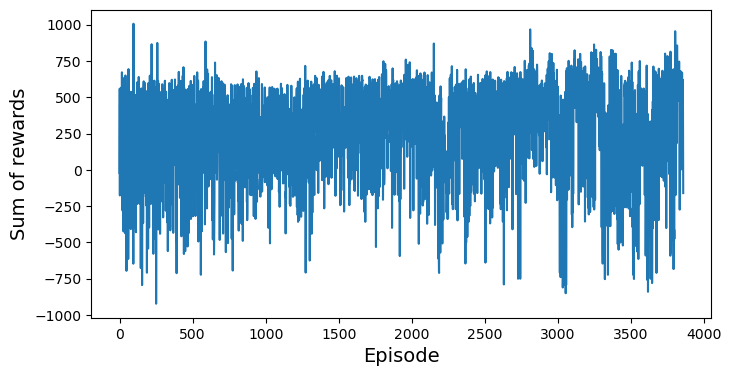

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
#save_fig("dqn_rewards_plot")
plt.show()

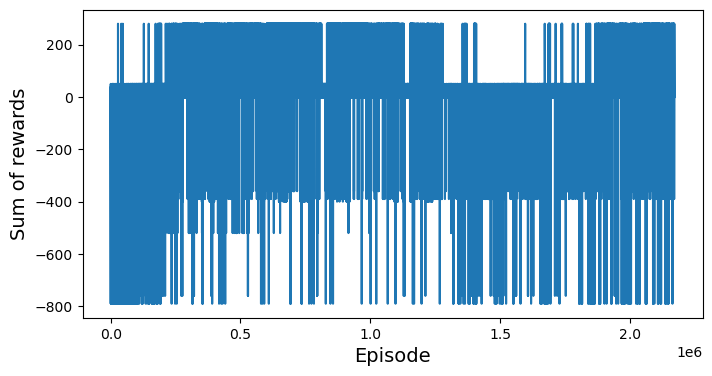

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards_per_jugada)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
#save_fig("dqn_rewards_plot")
plt.show()

El mapa final:

In [ ]:
snowman_env.show_map(SnowmanEnvironment.ENCODED_TEXT_MODE)
snowman_env.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  9.  9.  9.  9.  9.  0.  0.  0.  0.]
 [ 0.  0.  9.  0.  1.  0.  9.  0.  0.  0.  0.]
 [ 0.  0.  9.  1.  8. 11.  2.  0.  0.  0.  0.]
 [ 0.  0.  9.  0.  8.  0.  9.  0.  0.  0.  0.]
 [ 0.  0.  9.  9.  9.  9.  9.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[['#' '#' '#' '#' '#' '#' '#' '#' '#' '' '']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '' '']
 ['#' '#' '.' '.' '.' '.' '.' '#' '#' '' '']
 ['#' '#' '.' '#' '1' '#' '.' '#' '#' '' '']
 ['#' '#' '.' '1' ',' 'q' '2' '#' '#' '' '']
 ['#' '#' '.' '#' ',' '#' '.' '#' '#' '' '']
 ['#' '#' '.' '.' '.' '.' '.' '#' '#' '' '']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '' '']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '' '']]


Guardem el model:

In [ ]:
torch.save(training_agent.policy_net.state_dict(),save_path)

Carreguem el model i inferim:

In [ ]:
inferenceModel = DQN(1,n_actions, map_rows, map_cols).to(device)
inferenceModel.load_state_dict(torch.load(save_path))
inferenceModel.eval()

DQN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=1188, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=4, bias=True)
)

In [ ]:

inferenceEnvironment = SnowmanEnvironment(map_path, map_rows, map_cols)
done = False
max_steps = 100
steps = 0
while(not done and steps < max_steps):
    state = inferenceEnvironment.map
    state = torch.tensor([state], dtype=torch.float32, device=device).unsqueeze(0)
    action = inferenceModel(state).max(1).indices.view(1, 1)
    _, _, done, _ = inferenceEnvironment.step(action)
    inferenceEnvironment.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)
    print('\n')
    time.sleep(3)



setting agent position to  5 4
[['#' '#' '#' '#' '#' '#' '#' '#' '#' '' '']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '' '']
 ['#' '#' '.' '.' '.' '.' '.' '#' '#' '' '']
 ['#' '#' '.' '#' '1' '#' '.' '#' '#' '' '']
 ['#' '#' '.' '1' 'q' '1' '.' '#' '#' '' '']
 ['#' '#' '.' '#' ',' '#' '.' '#' '#' '' '']
 ['#' '#' '.' '.' '.' '.' '.' '#' '#' '' '']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '' '']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '' '']]


[['#' '#' '#' '#' '#' '#' '#' '#' '#' '' '']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '' '']
 ['#' '#' '.' '.' '.' '.' '.' '#' '#' '' '']
 ['#' '#' '.' '#' '1' '#' '.' '#' '#' '' '']
 ['#' '#' '.' '1' ',' '1' '.' '#' '#' '' '']
 ['#' '#' '.' '#' 'q' '#' '.' '#' '#' '' '']
 ['#' '#' '.' '.' '.' '.' '.' '#' '#' '' '']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '' '']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '' '']]


[['#' '#' '#' '#' '#' '#' '#' '#' '#' '' '']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '' '']
 ['#' '#' '.' '.' '.' '.' '.' '#' '#' '' '']
 ['#' '#' '.' '#' 

KeyboardInterrupt: 

In [ ]:

from environments.SnowmanEnvironment import SnowmanEnvironment
snowman_env_test = SnowmanEnvironment(map_file='./Dades/test.txt', 
                                 n=9, m=11, 
                                 stop_when_error=True, 
                                 stop_when_dumb=True, 
                                 enable_step_back_optimzation=True, 
                                 enable_blocked_snowman_optimization=True)
print(snowman_env_test.agent_position)
snowman_env_test.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)
#snowman_env_test.previous_agent_position = (2,6)
#snowman_env_test.agent_position = (2,6)
#a = snowman_env_test.adjust_reward(0,[5,4],[4,4])
print(a)
print(snowman_env_test.agent_position)
print("****************************************************************")
snowman_env_test.step(3)
snowman_env_test.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)




setting agent position to  5 4
(5, 4)
[['#' '#' '#' '#' '#' '#' '#' '#' '#' '' '']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '' '']
 ['#' '#' '.' '.' '.' '.' '.' '#' '#' '' '']
 ['#' '#' '.' '#' ',' '#' '.' '#' '#' '' '']
 ['#' '#' '.' '1' '1' '1' '.' '#' '#' '' '']
 ['#' '#' '.' '#' 'q' '#' '.' '#' '#' '' '']
 ['#' '#' '.' '.' '.' '.' '.' '#' '#' '' '']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '' '']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '' '']]
0
(5, 4)
****************************************************************
next_cell [4, 4]
next_of_next_cell [3, 4]
snowball_in_next_cell True
grass_or_snow_in_next_of_next_cell True
snowball_x, snowball_2 3 4
boolean test 1.0
has_horitzontal_cap True
has_vertical_cap False
[['#' '#' '#' '#' '#' '#' '#' '#' '#' '' '']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '' '']
 ['#' '#' '.' '.' '.' '.' '.' '#' '#' '' '']
 ['#' '#' '.' '#' '1' '#' '.' '#' '#' '' '']
 ['#' '#' '.' '1' 'q' '1' '.' '#' '#' '' '']
 ['#' '#' '.' '#' ',' '#' '.' '#' '#' '' '']
 ['#' '#' '